# Table of Contents: 
1. Goal of the Project
2. Import Libraries
3. Load Data
4. Exploratory Data Analysis (EDA)
    * 4.1 Data Dictionary
    * 4.2 General Info and Descriptive Statistics
    * 4.3 Remove Unnecessary Columns
    * 4.4 Rename Columns
    * 4.5 Missing Value Analysis and Imputation
    * 4.6 Duplicate Records Check
    * 4.7 Data Type Conversion
    * 4.8 Outlier Detection and Treatment
    * 4.9 Numerical Data Analysis
    * 4.10 Categorical Data Analysis
5. Feature Engineering
6. Insights and Observations

# 1. Goal of the Project

The goal of this project is to perform exploratory data analysis (EDA) and feature engineering to prepare the dataset for predicting refurb costs of vehicles in part-exchange. This includes understanding the data, handling missing values, identifying outliers, and creating relevant features to improve model performance.

# 2. Import Libraries

In [178]:
# install libraries
# uncomment the line if running first time
!pip install pandas numpy scikit-learn boto3 sagemaker mlflow xgboost

# import libraries
import pandas as pd
import numpy as np
import boto3
import sagemaker
from sagemaker import get_execution_role
import mlflow
import mlflow.sklearn
import os
import warnings
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from io import StringIO
import io

#display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 3. Load Data

In [179]:
# AWS Session Initialization
session = sagemaker.Session()
region = session.boto_region_name
role = get_execution_role()
s3 = boto3.client('s3')

In [180]:
bucket_name = 'sagemaker-bestcars-partex-data-storage'
object_key = 'data/raw/project_1_partex_valuation_data.xlsx' 

try:
    # Read the file content directly
    response = s3.get_object(Bucket=bucket_name, Key=object_key)
    file_content = response['Body'].read()
    df = pd.read_excel(io.BytesIO(file_content))
except Exception as e:
    print(f"Error reading the file: {e}")

[02/08/25 09:04:00] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=694770;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=517799;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py#487\487]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

In [181]:
df=df.copy()

# 4.  Exploratory Data Analysis (EDA)

## 4.1. Data Dictionary

📄General Vehicle Information

VRM: Vehicle Registration Mark (unique registration number).

VEHICLE_ID: Unique identifier for each vehicle.

VIN_VEHICLE_ID_RANK_DESC: Rank description based on the Vehicle Identification Number (VIN). --sasi numarasi

CAP_ID: Unique ID from the CAP database for vehicle valuation.

MMAF: Combined information of Make, Model, Age, and Fuel Type.

    
🚗 Vehicle Specifications

MAKE: Vehicle manufacturer (e.g., FIAT, JEEP).

MODEL: Vehicle model (e.g., 500C, AVENGER).

VEHICLE_TRIM: Trim level

COLOUR: Vehicle color.

BODY_TYPE: Vehicle body style (e.g., SUV, Convertible).

FUEL_TYPE: Type of fuel the vehicle uses (e.g., Petrol, Diesel).

TRANSMISSION_TYPE: Type of transmission system (e.g., Manual, Automatic).

REGISTERED_KEEPERS: Number of previous owners.

ODOMETER_MILES: Mileage of the vehicle (in miles).

VEHICLE_AGE_MONTHS: Age of the vehicle in months.

REGISTRATION_DATE: Date the vehicle was registered.

VEHICLE_SOURCE: Source of the vehicle (e.g., Outsourced, Trade-In)



🛠 Refurbishment (Repair) Information

ACTUAL_REFURB_COST: Actual refurbishment/repair cost for the vehicle.

AVG_CAPID_REFURB_COST: Average refurbishment cost for vehicles with the same CAP_ID.

AVG_MMAF_REFURB_COST: Average refurbishment cost for vehicles with the same MMAF grouping.

CAP_CLEAN: Clean market value of the vehicle according to the CAP system.

ALL_REFURB_DAYS_DIFF: Total number of days taken for the refurbishment process.

CAPID_DAYS_DIFF: Days difference related to the CAP_ID refurbishment timeline.

MMAF_DAYS_DIFF: Days difference related to the MMAF refurbishment timeline.

MAX_COMPLETE_DATE: Latest completion date of the refurbishment.

CREATED_DATE: The date when the vehicle record was created.


## 4.2. General Info and Descriptive Statistics

In [182]:
df.head()

,VRM,VEHICLE_ID,CREATED_DATE,VIN_VEHICLE_ID_RANK_DESC,CAP_ID,MMAF,MAKE,ACTUAL_REFURB_COST,MAX_COMPLETE_DATE,ALL_REFURB_DAYS_DIFF,CAPID_DAYS_DIFF,MMAF_DAYS_DIFF,VEHICLE_TRIM,AVG_CAPID_REFURB_COST,AVG_MMAF_REFURB_COST,CAP_CLEAN,VEHICLE_AGE__MONTHS,VEHICLE_SOURCE,TRANSMISSION_TYPE,REGISTERED_KEEPERS,ODOMETER_MILES,MODEL,COLOUR,BODY_TYPE,FUEL_TYPE,REGISTRATION_DATE
0,YY73XJV,268b15b3-9798-43ca-806c-0336d6ba4283,2024-08-07 14:36:53.390,1,104233.0,JEEPAVENGERLess than 1 Year OldPETROL,JEEP,267.390,2024-09-01,25,51.800,60.666,ALTITUDE,245.1756,246.600000,20250.0,7.366667,OUTSOURCED,MANUAL,2.0,8400.0,AVENGER,WHITE,SUV,Petrol,2023-12-30
1,YY73NJV,d095215e-7858-4001-b92d-fac15330c992,2024-09-09 22:50:17.370,1,101141.0,FIAT500C1 Years OldPETROL,FIAT,230.682,2024-09-16,7,42.866,51.125,NaN,269.4580,439.288125,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,30.0,500C,GREY,Convertible,Petrol,2023-09-30
2,YY73NHT,5594ceb5-f928-4e06-83a2-aba620aa2dd1,2024-09-09 22:50:20.220,1,101141.0,FIAT500C1 Years OldPETROL,FIAT,263.142,2024-11-21,73,42.866,51.125,NaN,269.4580,439.288125,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,34.0,500C,RED,Convertible,Petrol,2023-09-30
3,YY73NHN,979562e7-ca33-4752-b41b-38115f73f252,2024-09-09 22:50:17.573,1,101141.0,FIAT500C1 Years OldPETROL,FIAT,227.556,2024-09-20,11,42.866,51.125,NaN,269.4580,439.288125,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,28.0,500C,BLUE,Convertible,Petrol,2023-09-30
4,YY73NFN,918c93fe-f02b-4b76-8b12-94f60344a682,2024-09-09 22:50:17.504,1,101141.0,FIAT500CLess than 1 Year OldPETROL,FIAT,222.930,2024-10-05,26,42.866,24.500,NaN,269.4580,237.775000,12550.0,11.500000,OUTSOURCED,MANUAL,1.0,34.0,500C,RED,Convertible,Petrol,2023-09-30


In [183]:
df.columns

Index(['VRM', 'VEHICLE_ID', 'CREATED_DATE', 'VIN_VEHICLE_ID_RANK_DESC', 'CAP_ID', 'MMAF', 'MAKE', 'ACTUAL_REFURB_COST', 'MAX_COMPLETE_DATE', 'ALL_REFURB_DAYS_DIFF', 'CAPID_DAYS_DIFF', 'MMAF_DAYS_DIFF', 'VEHICLE_TRIM', 'AVG_CAPID_REFURB_COST', 'AVG_MMAF_REFURB_COST', 'CAP_CLEAN', 'VEHICLE_AGE__MONTHS', 'VEHICLE_SOURCE', 'TRANSMISSION_TYPE', 'REGISTERED_KEEPERS', 'ODOMETER_MILES', 'MODEL', 'COLOUR', 'BODY_TYPE', 'FUEL_TYPE', 'REGISTRATION_DATE'], dtype='object')

In [184]:
# General information and summary statistics
print("\nGeneral Information:\n")
df.info()


General Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54884 entries, 0 to 54883
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   VRM                       54884 non-null  object        
 1   VEHICLE_ID                54884 non-null  object        
 2   CREATED_DATE              54884 non-null  datetime64[ns]
 3   VIN_VEHICLE_ID_RANK_DESC  54884 non-null  int64         
 4   CAP_ID                    54883 non-null  float64       
 5   MMAF                      54878 non-null  object        
 6   MAKE                      54884 non-null  object        
 7   ACTUAL_REFURB_COST        54884 non-null  float64       
 8   MAX_COMPLETE_DATE         54884 non-null  datetime64[ns]
 9   ALL_REFURB_DAYS_DIFF      54884 non-null  int64         
 10  CAPID_DAYS_DIFF           54884 non-null  float64       
 11  MMAF_DAYS_DIFF            54884 non-null  float64       


There are :

* 12 numeric columns

* 11 objects columns

* 3 datetime columns

In [185]:
df.nunique().sort_values(ascending=False)

VRM                         54884
VEHICLE_ID                  54884
CREATED_DATE                54023
ACTUAL_REFURB_COST          46520
ODOMETER_MILES              36492
CAP_ID                       9307
AVG_CAPID_REFURB_COST        9258
CAPID_DAYS_DIFF              3433
AVG_MMAF_REFURB_COST         3033
MMAF                         3033
VEHICLE_AGE__MONTHS          3009
REGISTRATION_DATE            2629
MMAF_DAYS_DIFF               2054
VEHICLE_TRIM                 1067
CAP_CLEAN                     793
MODEL                         425
MAX_COMPLETE_DATE             357
ALL_REFURB_DAYS_DIFF          234
MAKE                           43
COLOUR                         29
REGISTERED_KEEPERS             10
VIN_VEHICLE_ID_RANK_DESC        8
BODY_TYPE                       7
FUEL_TYPE                       4
TRANSMISSION_TYPE               3
VEHICLE_SOURCE                  2
dtype: int64

## 4.3. Remove unncessary columns

* 'VRM' and 'VEHICLE_ID' are unique for each car so that they will be removed.

In [186]:
# df = df.drop(["VRM", "VEHICLE_ID"], axis=1)

## 4.4. Rename columns

* There is a type error  for the columnn 'VEHICLE_AGE__MONTHS' that needs to be fixed.

In [187]:
# renaming columns
df = df.rename(columns={"VEHICLE_AGE__MONTHS": "VEHICLE_AGE_MONTHS"})

## 4.5. Missing Value Analysis and Imputation

In [188]:
# Check for missing values
print("\nMissing Values:\n")
print(df.isnull().sum().sort_values(ascending=False))


Missing Values:

VEHICLE_TRIM                699
REGISTERED_KEEPERS          175
CAP_CLEAN                    31
TRANSMISSION_TYPE            14
BODY_TYPE                    14
COLOUR                       12
FUEL_TYPE                    10
MMAF                          6
ODOMETER_MILES                1
CAP_ID                        1
ALL_REFURB_DAYS_DIFF          0
MAX_COMPLETE_DATE             0
ACTUAL_REFURB_COST            0
MAKE                          0
CREATED_DATE                  0
VIN_VEHICLE_ID_RANK_DESC      0
VRM                           0
VEHICLE_ID                    0
VEHICLE_SOURCE                0
VEHICLE_AGE_MONTHS            0
AVG_MMAF_REFURB_COST          0
AVG_CAPID_REFURB_COST         0
CAPID_DAYS_DIFF               0
MMAF_DAYS_DIFF                0
MODEL                         0
REGISTRATION_DATE             0
dtype: int64


In [189]:
# Calculate missing value counts and percentages
missing_counts = df.isnull().sum()
missing_percentages =df.isnull().mean() * 100

missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentages
}).reset_index(drop=True)

missing_df = missing_df.sort_values(by='Missing_Percentage', ascending=False)
missing_df


,Column,Missing_Count,Missing_Percentage
12,VEHICLE_TRIM,699,1.273595
19,REGISTERED_KEEPERS,175,0.318854
15,CAP_CLEAN,31,0.056483
18,TRANSMISSION_TYPE,14,0.025508
23,BODY_TYPE,14,0.025508
22,COLOUR,12,0.021864
24,FUEL_TYPE,10,0.018220
5,MMAF,6,0.010932
20,ODOMETER_MILES,1,0.001822
4,CAP_ID,1,0.001822


In [190]:
def handle_missing_values(df):
    # Step 1: Drop columns with more than 10% missing values
    missing_percentage = df.isnull().mean() * 100
    columns_to_drop = missing_percentage[missing_percentage > 10].index
    
    if len(columns_to_drop) > 0:
        df = df.drop(columns=columns_to_drop)
        print(f"Dropped columns: {columns_to_drop.tolist()} because they have more than 10% missing values.")
    
    # Step 2: Fill missing values in remaining columns based on MMAF group
    missing_columns = df.columns[df.isnull().any()]
    
    for col in missing_columns:
        if df[col].dtype == 'object':  # For categorical columns
            # Fill missing values using the mode within the MMAF grouping
            df[col] = df.groupby('MMAF')[col].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown'))
            print(f"Filled missing values for {col} (Categorical) using mode by MMAF")
        else:  # For numeric columns
            # Fill missing values using the median within the MMAF grouping
            df[col] = df.groupby('MMAF')[col].apply(lambda x: x.fillna(x.median()))
            print(f"Filled missing values for {col} (Numeric) using median by MMAF")
    # Step 3: Drop rows with any remaining missing values
    rows_before_drop = df.shape[0]
    df_cleaned = df.dropna()  # Drop rows with any missing values
    
    rows_after_drop = df_cleaned.shape[0]
    rows_dropped = df.shape[0] - df_cleaned.shape[0]  # Calculate rows dropped
    
    print(f"\n{rows_dropped} rows were dropped due to missing values.")
    
    return df_cleaned


In [191]:
# Apply the function to handle missing values
df_cleaned = handle_missing_values(df)

Filled missing values for CAP_ID (Numeric) using median by MMAF
Filled missing values for MMAF (Categorical) using mode by MMAF
Filled missing values for VEHICLE_TRIM (Categorical) using mode by MMAF
Filled missing values for CAP_CLEAN (Numeric) using median by MMAF
Filled missing values for TRANSMISSION_TYPE (Categorical) using mode by MMAF
Filled missing values for REGISTERED_KEEPERS (Numeric) using median by MMAF
Filled missing values for ODOMETER_MILES (Numeric) using median by MMAF
Filled missing values for COLOUR (Categorical) using mode by MMAF
Filled missing values for BODY_TYPE (Categorical) using mode by MMAF
Filled missing values for FUEL_TYPE (Categorical) using mode by MMAF

13 rows were dropped due to missing values.


* 13 rows droped due to missing values

## 4.6. Duplicate Records Check

In [192]:
df_cleaned[df_cleaned.duplicated()] 

,VRM,VEHICLE_ID,CREATED_DATE,VIN_VEHICLE_ID_RANK_DESC,CAP_ID,MMAF,MAKE,ACTUAL_REFURB_COST,MAX_COMPLETE_DATE,ALL_REFURB_DAYS_DIFF,CAPID_DAYS_DIFF,MMAF_DAYS_DIFF,VEHICLE_TRIM,AVG_CAPID_REFURB_COST,AVG_MMAF_REFURB_COST,CAP_CLEAN,VEHICLE_AGE_MONTHS,VEHICLE_SOURCE,TRANSMISSION_TYPE,REGISTERED_KEEPERS,ODOMETER_MILES,MODEL,COLOUR,BODY_TYPE,FUEL_TYPE,REGISTRATION_DATE


* There is no duplicate records.

In [193]:
# remove duplicates
df_cleaned = df_cleaned.drop_duplicates()  

 ## 4.7. Data Type Conversion

In [194]:
df_cleaned.nunique().sort_values(ascending=False)

VRM                         54871
VEHICLE_ID                  54871
CREATED_DATE                54010
ACTUAL_REFURB_COST          46508
ODOMETER_MILES              36489
CAP_ID                       9301
AVG_CAPID_REFURB_COST        9251
CAPID_DAYS_DIFF              3433
MMAF                         3027
AVG_MMAF_REFURB_COST         3026
VEHICLE_AGE_MONTHS           3009
REGISTRATION_DATE            2629
MMAF_DAYS_DIFF               2051
VEHICLE_TRIM                 1068
CAP_CLEAN                     799
MODEL                         421
MAX_COMPLETE_DATE             357
ALL_REFURB_DAYS_DIFF          234
MAKE                           43
COLOUR                         29
REGISTERED_KEEPERS             11
VIN_VEHICLE_ID_RANK_DESC        8
BODY_TYPE                       7
FUEL_TYPE                       4
TRANSMISSION_TYPE               3
VEHICLE_SOURCE                  2
dtype: int64

In [195]:
def convert_numeric_to_categorical(df, threshold=15):
    """
    This function checks numeric columns in the dataframe and converts them to categorical
    if the number of unique values is less than the specified threshold.
    
    Parameters:
    - df: DataFrame, the dataframe to process
    - threshold: int, the threshold for unique values to decide if a column should be categorical
    
    Returns:
    - df: DataFrame with numeric columns converted to categorical based on the threshold
    """
    # Iterate over all columns in the dataframe
    for column in df.select_dtypes(include=['number']).columns:
        # Get the number of unique values in the column
        unique_values_count = df[column].nunique()
        
        # If the number of unique values is less than the threshold, convert to categorical
        if unique_values_count < threshold:
            df[column] = df[column].astype('category')
            print(f"Column '{column}' converted to categorical (less than {threshold} unique values).")
        else:
            print(f"Column '{column}' remains numeric (more than {threshold} unique values).")
    
    return df

# Example usage: Convert numeric columns with less than 15 unique values to categorical
df_cleaned = convert_numeric_to_categorical(df_cleaned, threshold=15)


Column 'VIN_VEHICLE_ID_RANK_DESC' converted to categorical (less than 15 unique values).
Column 'CAP_ID' remains numeric (more than 15 unique values).
Column 'ACTUAL_REFURB_COST' remains numeric (more than 15 unique values).
Column 'ALL_REFURB_DAYS_DIFF' remains numeric (more than 15 unique values).
Column 'CAPID_DAYS_DIFF' remains numeric (more than 15 unique values).
Column 'MMAF_DAYS_DIFF' remains numeric (more than 15 unique values).
Column 'AVG_CAPID_REFURB_COST' remains numeric (more than 15 unique values).
Column 'AVG_MMAF_REFURB_COST' remains numeric (more than 15 unique values).
Column 'CAP_CLEAN' remains numeric (more than 15 unique values).
Column 'VEHICLE_AGE_MONTHS' remains numeric (more than 15 unique values).
Column 'REGISTERED_KEEPERS' converted to categorical (less than 15 unique values).
Column 'ODOMETER_MILES' remains numeric (more than 15 unique values).


In [196]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54871 entries, 0 to 54883
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   VRM                       54871 non-null  object        
 1   VEHICLE_ID                54871 non-null  object        
 2   CREATED_DATE              54871 non-null  datetime64[ns]
 3   VIN_VEHICLE_ID_RANK_DESC  54871 non-null  category      
 4   CAP_ID                    54871 non-null  float64       
 5   MMAF                      54871 non-null  object        
 6   MAKE                      54871 non-null  object        
 7   ACTUAL_REFURB_COST        54871 non-null  float64       
 8   MAX_COMPLETE_DATE         54871 non-null  datetime64[ns]
 9   ALL_REFURB_DAYS_DIFF      54871 non-null  int64         
 10  CAPID_DAYS_DIFF           54871 non-null  float64       
 11  MMAF_DAYS_DIFF            54871 non-null  float64       
 12  VEHICLE_TRIM      

## 4.8. Outlier Detection and Treatment

In [197]:
def detect_and_remove_outliers(df, columns, z_score_threshold=3, iqr_threshold=1.5, visualize=True):
    """
    Detects and removes outliers from specified columns of the DataFrame.
    
    Args:
    df (pandas.DataFrame): The input DataFrame containing the data.
    columns (list): A list of column names to perform outlier detection on.
    z_score_threshold (float): The Z-Score threshold for detecting outliers. Default is 3.
    iqr_threshold (float): The IQR threshold for detecting outliers. Default is 1.5.
    visualize (bool): Whether to display boxplots for each column before and after removing outliers. Default is True.
    
    Returns:
    pandas.DataFrame: The cleaned DataFrame with outliers removed.
    pandas.DataFrame: Summary DataFrame showing outliers removed and methods used.
    """
    # Dictionary to track the outliers count and method for each column
    outlier_info = {}

    # Iterate over each column provided
    for column in columns:
        if column not in df.columns:
            outlier_info[column] = {"outliers_removed": 0, "method": "N/A"}
            continue
        
        # Initialize the figure for the visualizations
        if visualize:
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            
            # Visualize the boxplot before removing outliers
            sns.boxplot(x=df[column], ax=axes[0])
            axes[0].set_title(f"Boxplot for {column} - Before Removing Outliers")
        
        # Normality check using Shapiro-Wilk Test
        _, p_value = stats.shapiro(df[column].dropna())  # Null values are dropped for normality test
        
        # Initialize outliers count
        initial_outliers = df[column].isna().sum()
        
        # If p-value > 0.05, data is normally distributed, Z-Score method will be applied
        if p_value > 0.05:
            # Z-Score outlier detection (used for normal distribution)
            z_scores = np.abs(stats.zscore(df[column].dropna()))  # Calculate Z-Scores
            outliers = df[column][z_scores > z_score_threshold]  # Consider Z-Scores greater than threshold as outliers
            
            # Remove outliers
            df = df[z_scores <= z_score_threshold]
            
            # Track outlier count and method
            outlier_info[column] = {"outliers_removed": len(outliers), "method": "Z-Score"}
        
        else:
            # IQR outlier detection (used for skewed or non-normal data)
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_threshold * IQR
            upper_bound = Q3 + iqr_threshold * IQR
            outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
            
            # Remove outliers
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
            
            # Track outlier count and method
            outlier_info[column] = {"outliers_removed": len(outliers), "method": "IQR"}
        
        # Visualize the boxplot after removing outliers
        if visualize:
            sns.boxplot(x=df[column], ax=axes[1])
            axes[1].set_title(f"Boxplot for {column} - After Removing Outliers")
            plt.tight_layout()
            plt.show()

    # Summary of outliers removal - Creating a DataFrame to display the summary
    outlier_summary = pd.DataFrame.from_dict(outlier_info, orient='index')
    outlier_summary.columns = ['Outliers Removed', 'Method']

    # Print the summary of outliers removed
    print("\nOutlier Detection Summary:")
    print(outlier_summary)
    
    # Return the cleaned DataFrame (without outliers) and the summary (as a DataFrame)
    return df, outlier_summary


In [198]:
# numerical_columns = df_cleaned.select_dtypes(include=['float64','int64']).columns
numerical_columns = ['ACTUAL_REFURB_COST', 'ALL_REFURB_DAYS_DIFF', 'CAPID_DAYS_DIFF', 'MMAF_DAYS_DIFF', 'AVG_CAPID_REFURB_COST', 'AVG_MMAF_REFURB_COST', 'CAP_CLEAN', 'VEHICLE_AGE_MONTHS', 'ODOMETER_MILES']

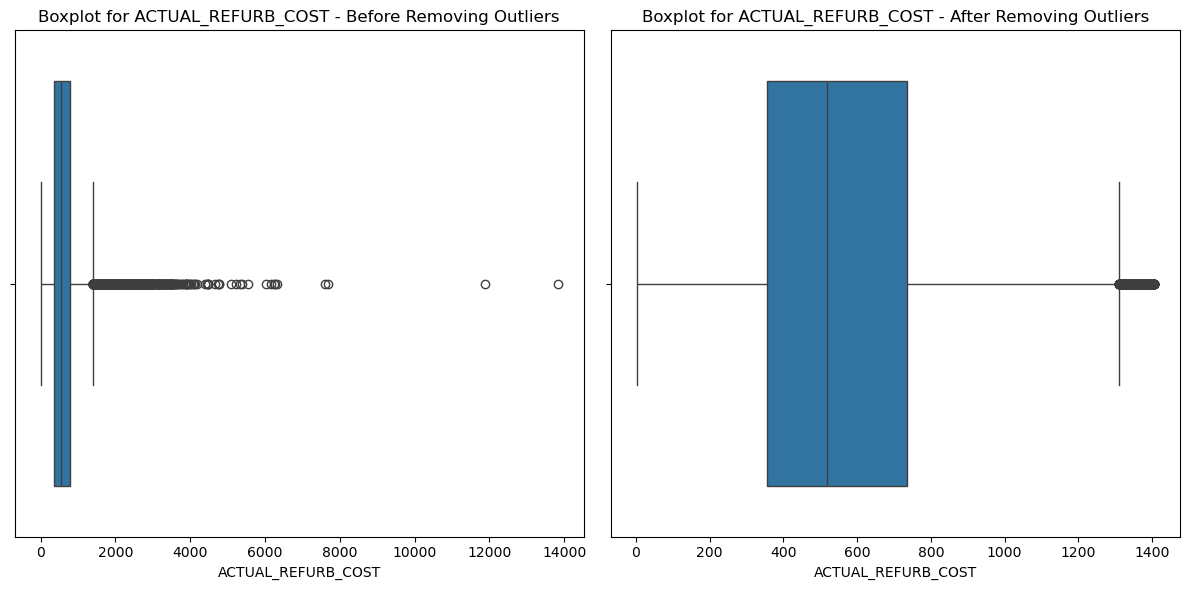

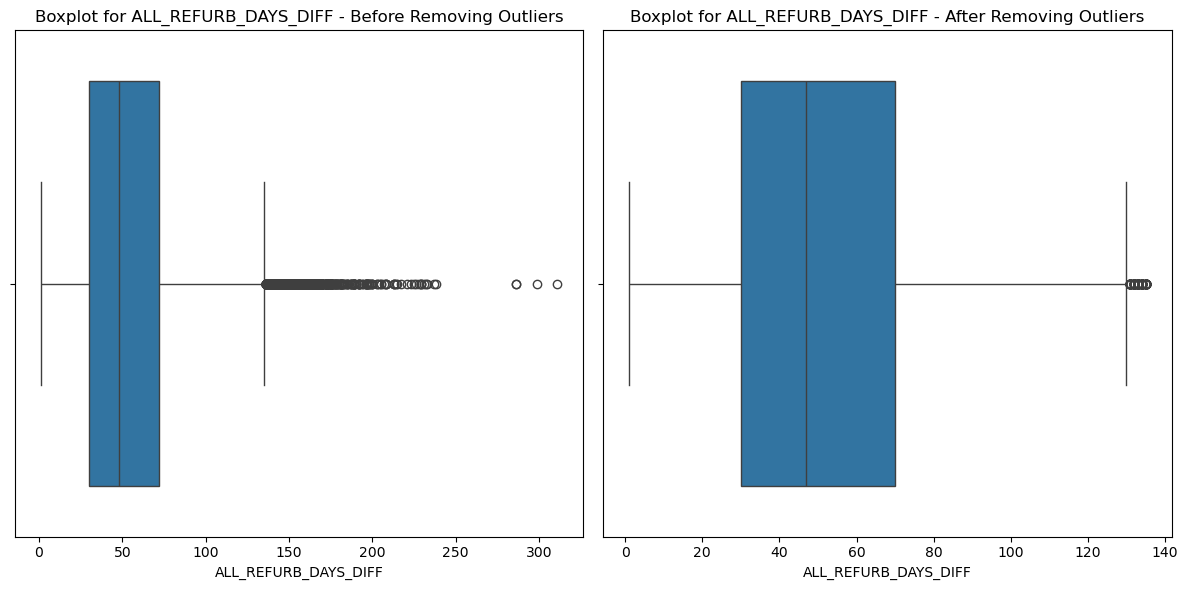

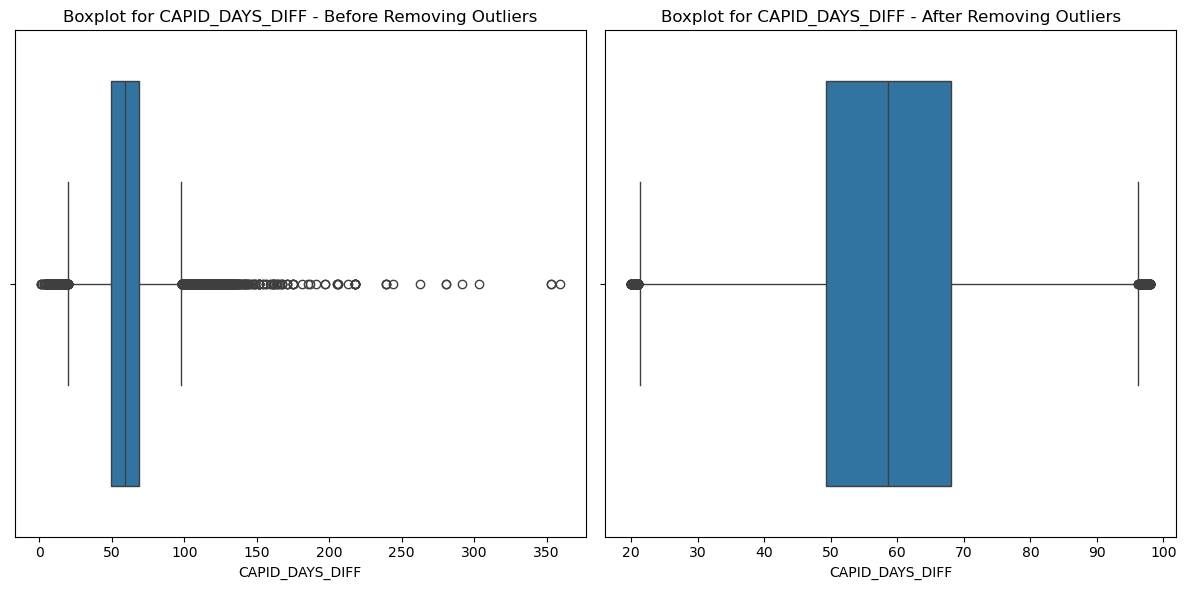

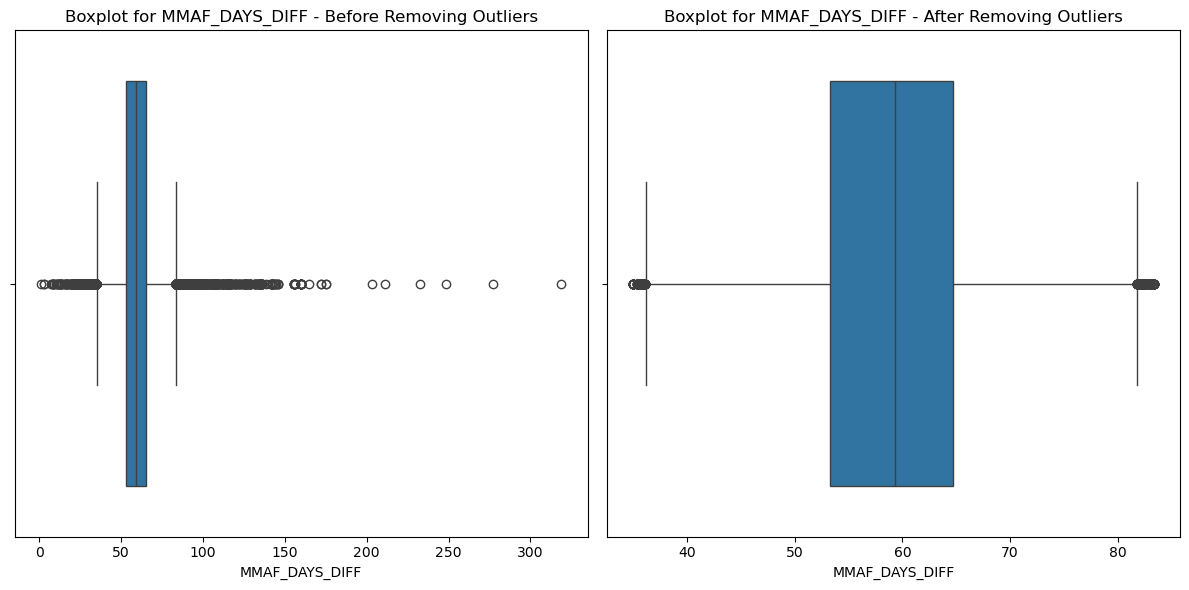

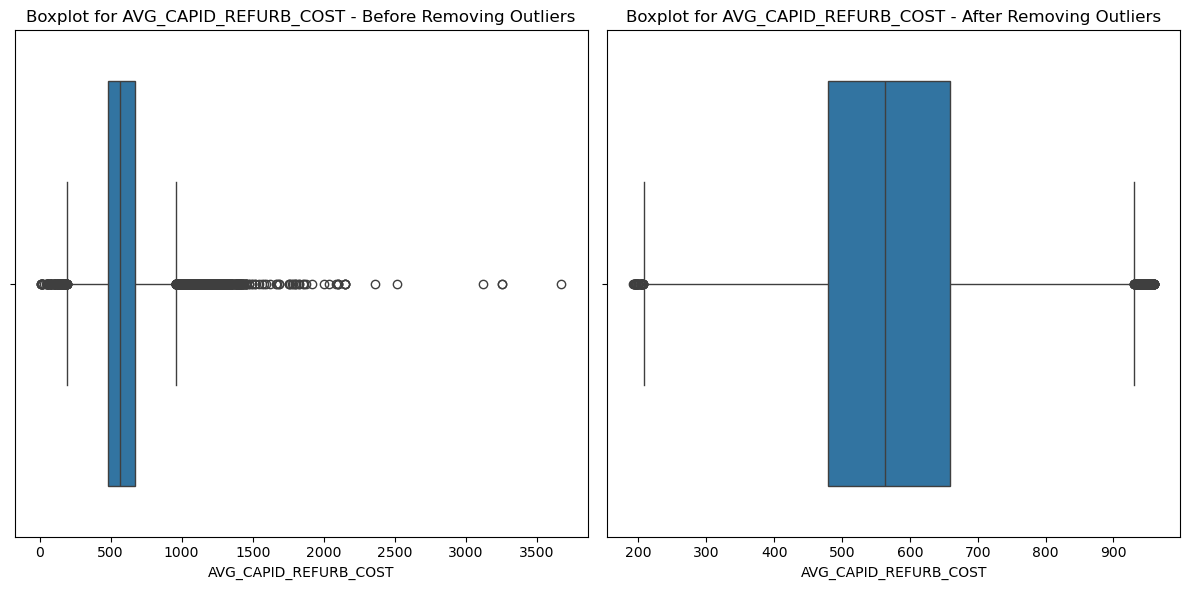

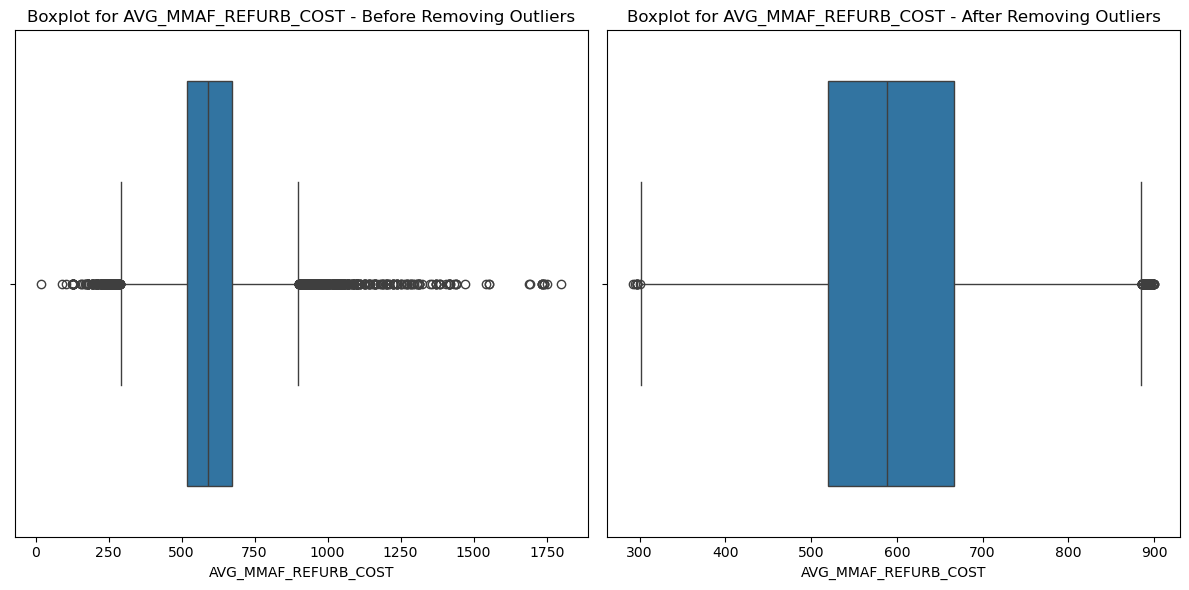

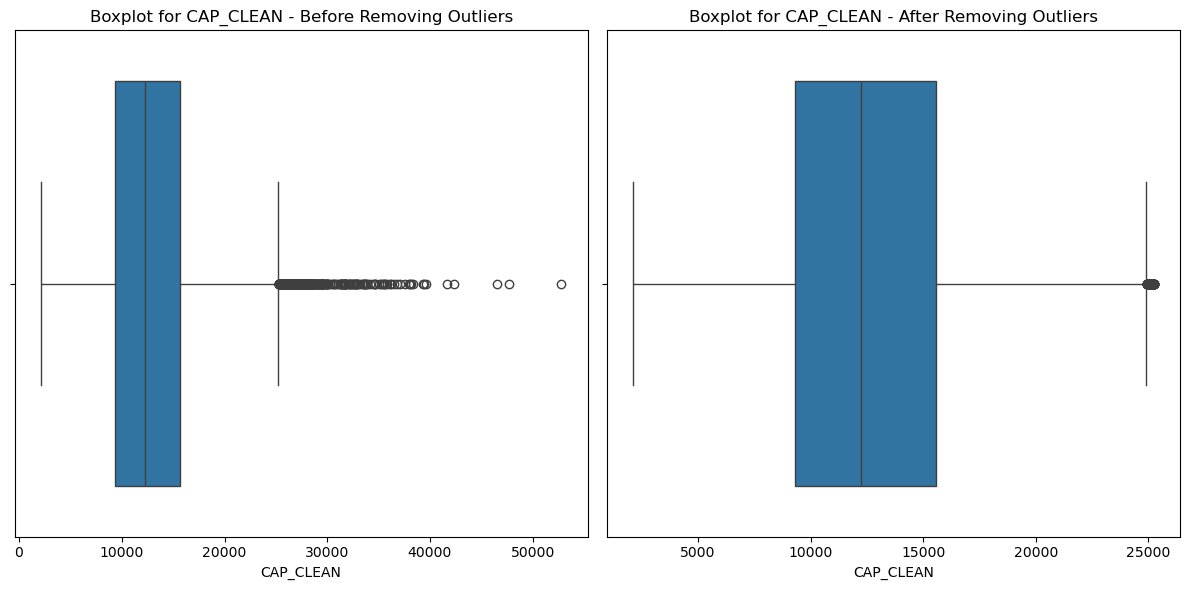

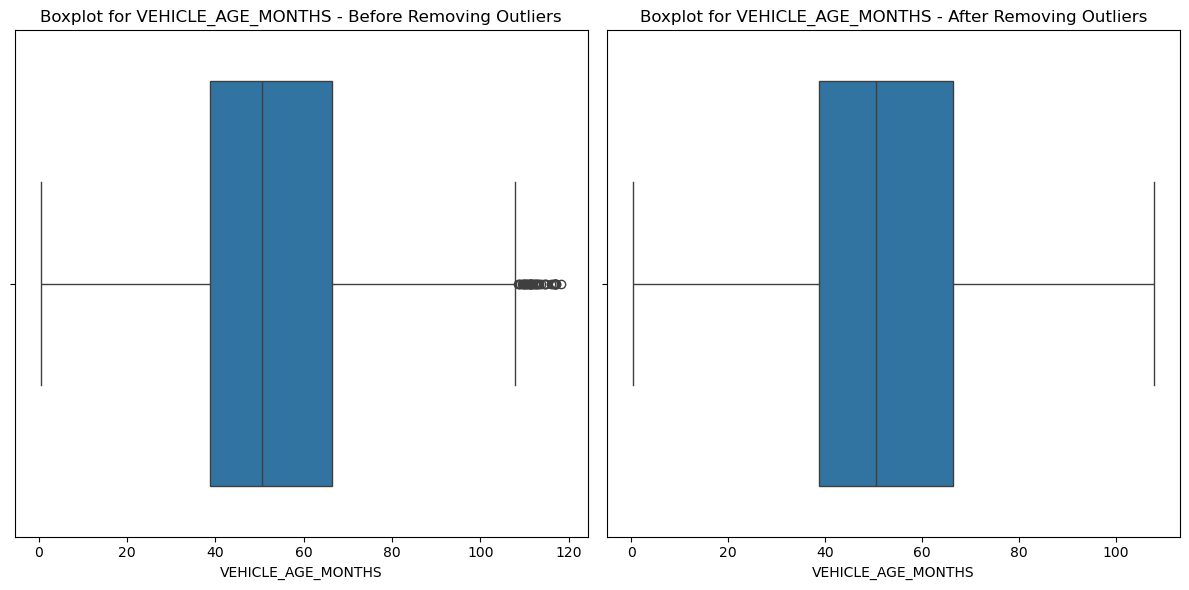

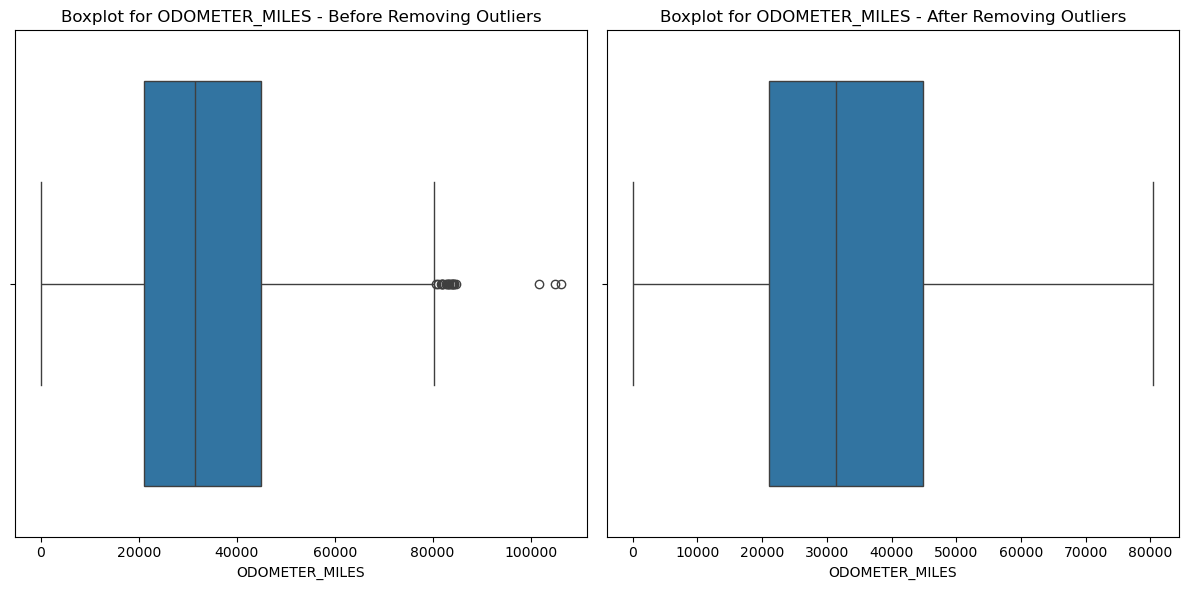


Outlier Detection Summary:
                       Outliers Removed Method
ACTUAL_REFURB_COST                 2391    IQR
ALL_REFURB_DAYS_DIFF                964    IQR
CAPID_DAYS_DIFF                    1526    IQR
MMAF_DAYS_DIFF                     1949    IQR
AVG_CAPID_REFURB_COST              1528    IQR
AVG_MMAF_REFURB_COST               1141    IQR
CAP_CLEAN                           479    IQR
VEHICLE_AGE_MONTHS                   39    IQR
ODOMETER_MILES                       21    IQR

Cleaned DataFrame (Without Outliers):
       VRM                            VEHICLE_ID            CREATED_DATE VIN_VEHICLE_ID_RANK_DESC    CAP_ID                       MMAF  MAKE  ACTUAL_REFURB_COST MAX_COMPLETE_DATE  ALL_REFURB_DAYS_DIFF  CAPID_DAYS_DIFF  MMAF_DAYS_DIFF VEHICLE_TRIM  AVG_CAPID_REFURB_COST  AVG_MMAF_REFURB_COST  CAP_CLEAN  VEHICLE_AGE_MONTHS VEHICLE_SOURCE TRANSMISSION_TYPE REGISTERED_KEEPERS  ODOMETER_MILES MODEL COLOUR    BODY_TYPE FUEL_TYPE REGISTRATION_DATE
1  YY73NJV  d09521

In [199]:
df_cleaned_after_outlier, outlier_summary = detect_and_remove_outliers(df_cleaned, numerical_columns, visualize=True)

# Cleaned DataFrame
print("\nCleaned DataFrame (Without Outliers):")
print(df_cleaned_after_outlier.head())

# Outlier Removal Summary
print("\nOutlier Removal Summary:")
print(outlier_summary)

## 4.9. Numerical Data Analysis

In [200]:
def plot_numerical_distributions_and_relationships(df, target_column='ACTUAL_REFURB_COST'):
    # Select all numeric columns
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Number of plots (rows) to create
    num_plots = len(numerical_columns)
    
    # Create subplots with 2 columns (one for histogram, one for scatter plot)
    fig, axes = plt.subplots(num_plots, 2, figsize=(12, 6 * num_plots))
    
    for idx, column in enumerate(numerical_columns):
        # Plot histogram for each numerical column in the first column of the subplot
        sns.histplot(df[column], kde=True, ax=axes[idx, 0])
        axes[idx, 0].set_title(f'Histogram of {column}')
        
        # Plot scatter plot showing the relationship with refurb cost in the second column
        sns.scatterplot(x=df[column], y=df[target_column], ax=axes[idx, 1])
        axes[idx, 1].set_title(f'Scatter of {column} vs {target_column}')
        axes[idx, 1].set_xlabel(column)
        axes[idx, 1].set_ylabel(target_column)
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    
    # Compute the correlation matrix for numerical columns
    correlation_matrix = df[numerical_columns].corr()
    
    # Plot the heatmap for the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap of Numeric Features')
    
    # Show all plots
    plt.show()

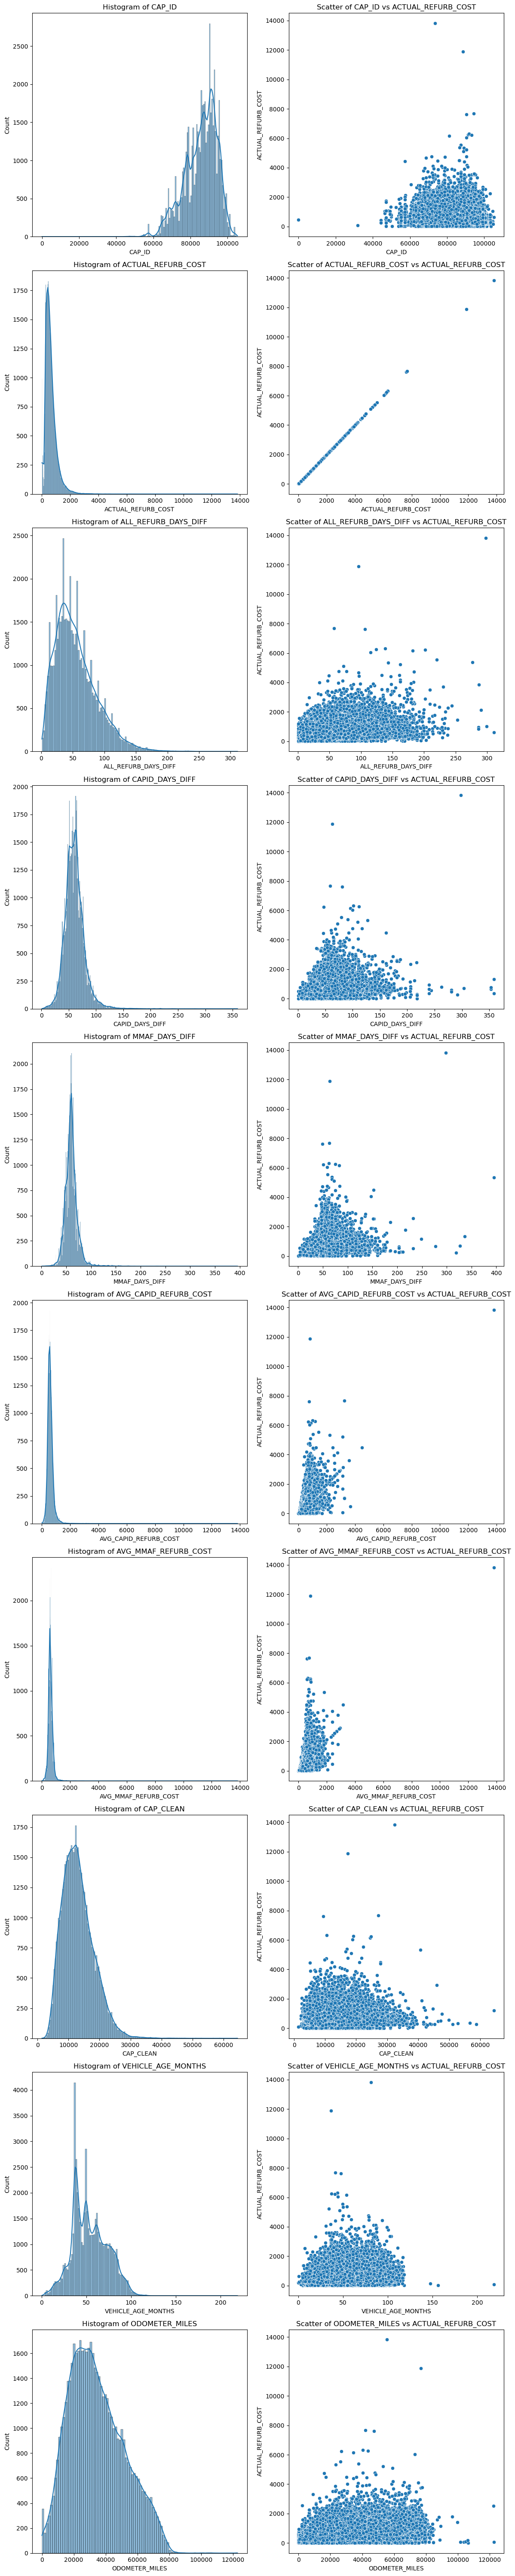

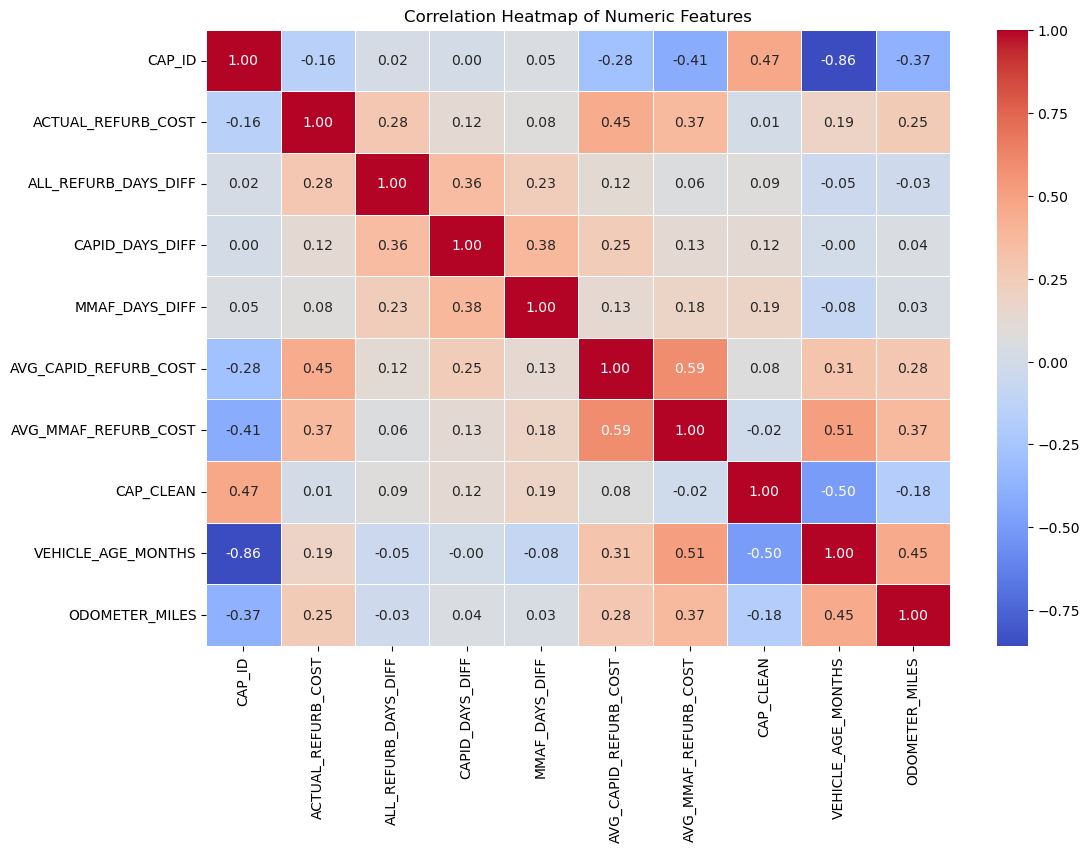

In [201]:
plot_numerical_distributions_and_relationships(df_cleaned)

## 4.10. Categorical Data Analysis

In [202]:
def categorical_data_summary(df, target_column='ACTUAL_REFURB_COST'):
    """
    Function to generate summary statistics and visualizations for categorical columns,
    along with their relationship with a numerical column (e.g., refurb cost).
    
    Args:
    df (pandas.DataFrame): The input DataFrame.
    target_column (str): The numerical column to analyze against categorical columns.
    
    Returns:
    None (Displays summary and visualizations)
    """
    # 1. Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # 2. Display summary statistics for categorical columns
    #print("\nSummary Statistics for Categorical Columns:")
    #for column in categorical_cols:
    #    print(f"\n{column} - Value Counts:")
    #    print(df[column].value_counts())

    # 3. Visualize the distribution of each categorical column only if number of categories <= 15
    plt.figure(figsize=(12, 5 * len(categorical_cols)))
    for i, column in enumerate(categorical_cols, 1):
        unique_categories = df[column].nunique()
        
        # Only visualize columns with 15 or fewer unique categories
        if unique_categories <= 15:
            plt.subplot(len(categorical_cols), 1, i)
            sns.countplot(x=df[column], palette='Set2')
            plt.title(f"Distribution of {column}")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

    # 4. Plot relationship with target_column (e.g., refurb cost) if numeric
    if target_column in df.columns and pd.api.types.is_numeric_dtype(df[target_column]):
        plt.figure(figsize=(12, 5 * len(categorical_cols)))
        for i, column in enumerate(categorical_cols, 1):
            unique_categories = df[column].nunique()
            
            # Only visualize columns with 15 or fewer unique categories
            if unique_categories <= 15:
                plt.subplot(len(categorical_cols), 1, i)
                sns.boxplot(x=df[column], y=df[target_column], palette='Set2')
                plt.title(f"{target_column} vs {column}")
                plt.xlabel(column)
                plt.ylabel(target_column)
                plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n{target_column} column is missing or not numeric.")


[02/08/25 09:05:12] INFO     Using categorical units to plot a list of strings that are all         ]8;id=580444;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=374591;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=311540;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=635872;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

[02/08/25 09:05:13] INFO     Using categorical units to plot a list of strings that are all         ]8;id=203535;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=432359;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=231403;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=510608;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

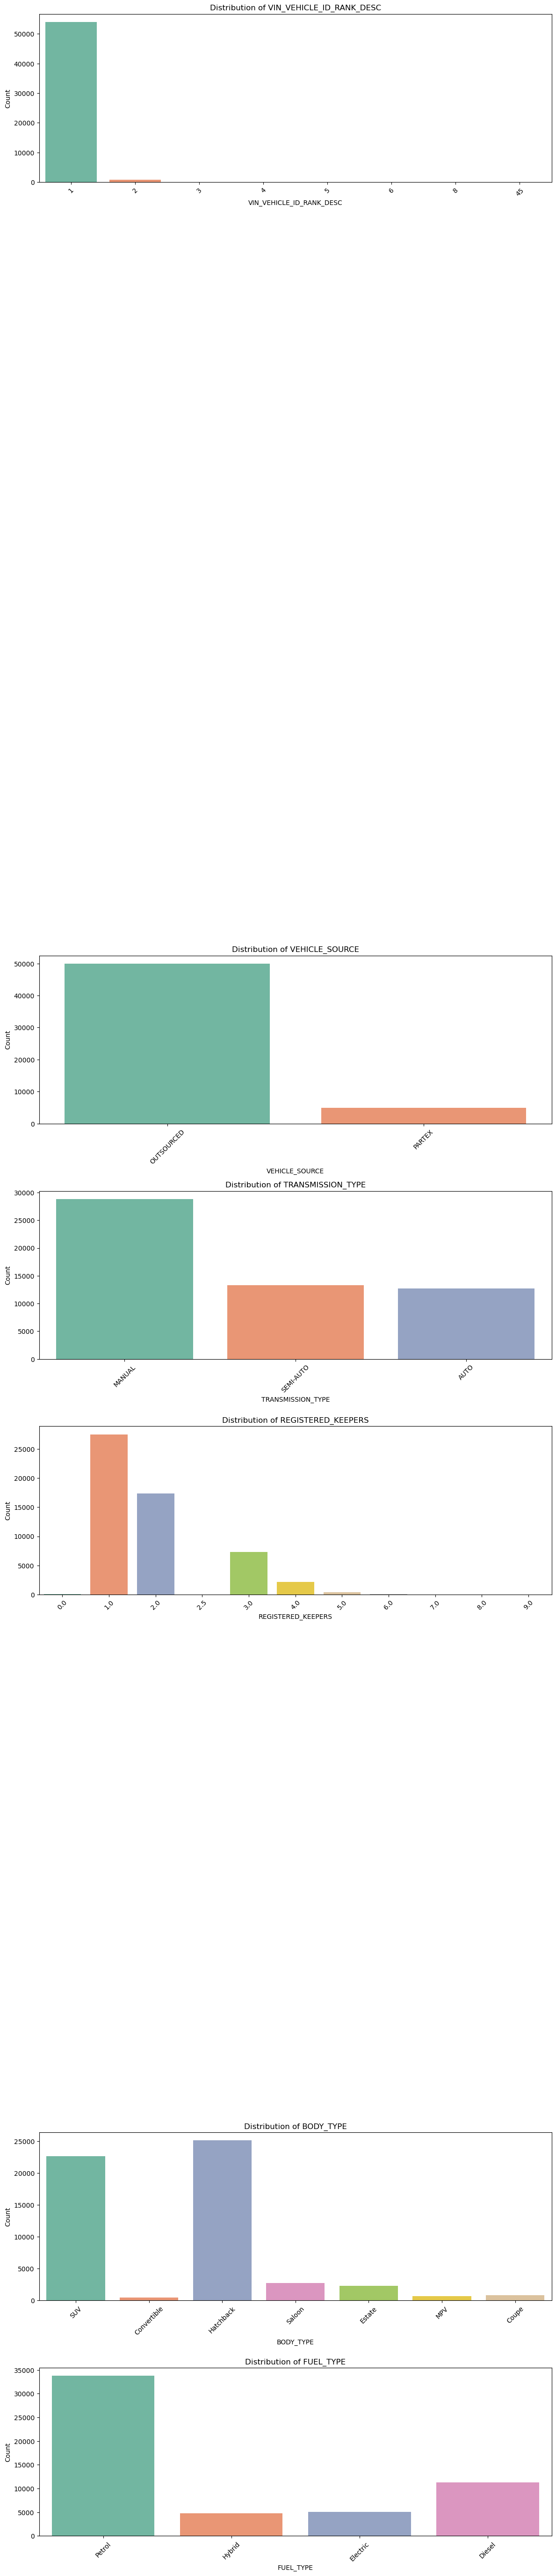

[02/08/25 09:05:15] INFO     Using categorical units to plot a list of strings that are all         ]8;id=368065;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=511672;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=323576;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=895850;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

[02/08/25 09:05:16] INFO     Using categorical units to plot a list of strings that are all         ]8;id=234264;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=344587;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=879397;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=925022;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

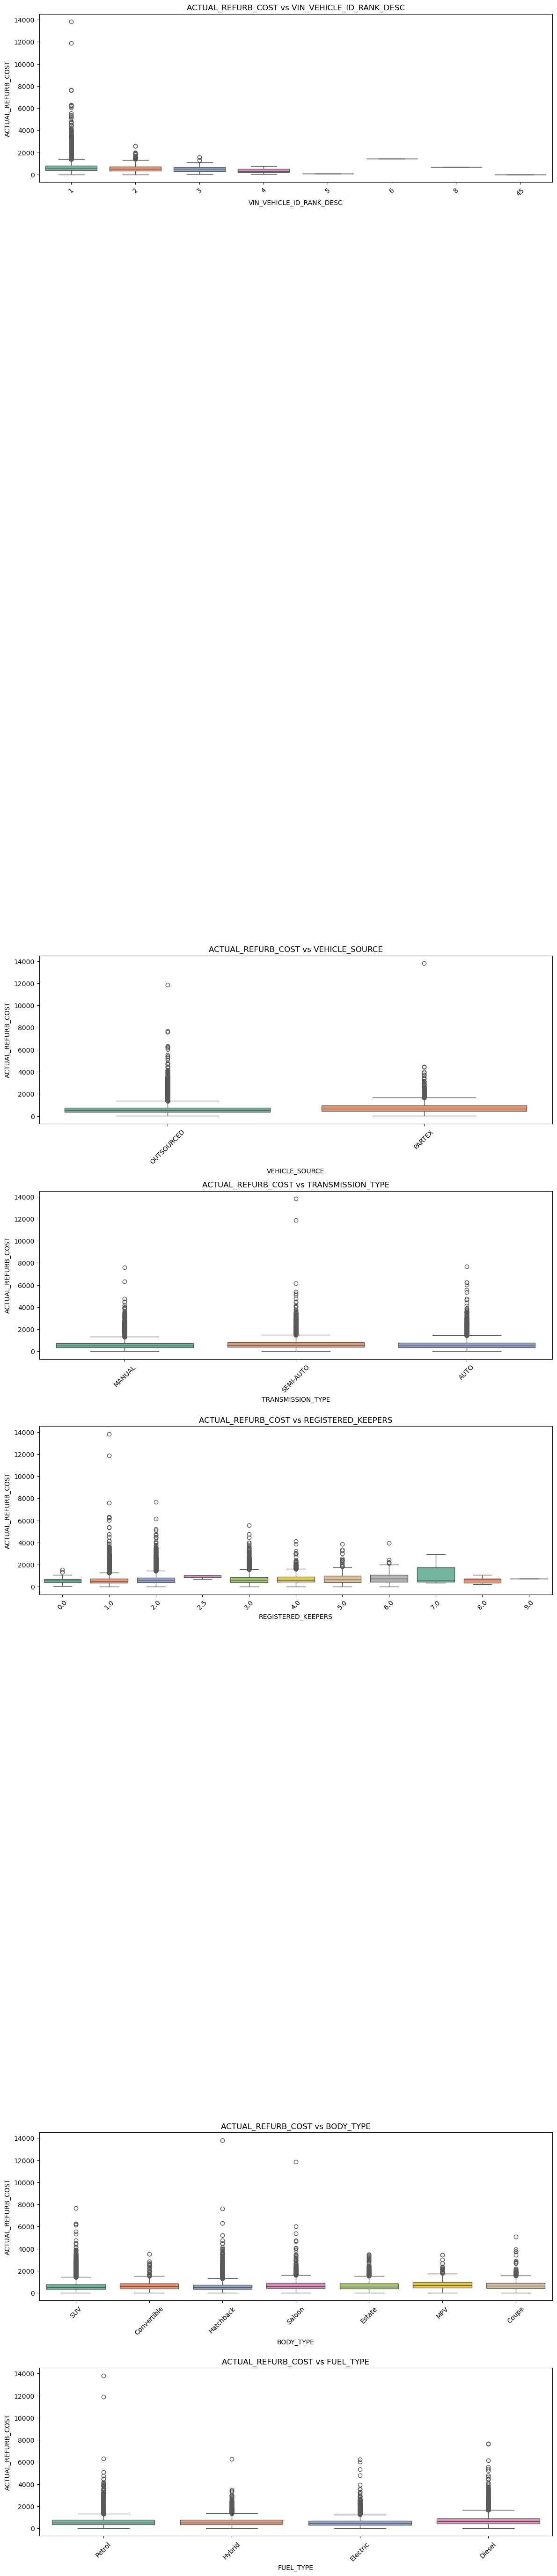

In [203]:
categorical_data_summary(df_cleaned)

In [205]:
source_analysis = df.groupby('VEHICLE_SOURCE').agg(
    avg_refurb_cost=('ACTUAL_REFURB_COST', 'mean'),
    avg_odometer_miles=('ODOMETER_MILES', 'mean'),
    avg_vehicle_age_months=('VEHICLE_AGE_MONTHS', 'mean'),
    avg_make=('MAKE', 'nunique'),
    avg_model=('MODEL', 'nunique')
).reset_index()

# Display the result
source_analysis

,VEHICLE_SOURCE,avg_refurb_cost,avg_odometer_miles,avg_vehicle_age_months,avg_make,avg_model
0,OUTSOURCED,611.649000,33689.986186,52.248029,42,400
1,PARTEX,739.292486,41804.703742,70.620301,40,332


In [206]:
# Group by BODY_TYPE and calculate the average refurbishment cost
body_type_analysis = df.groupby('BODY_TYPE').agg(
    avg_refurb_cost=('ACTUAL_REFURB_COST', 'mean'),
    avg_odometer_miles=('ODOMETER_MILES', 'mean'),
    avg_vehicle_age_months=('VEHICLE_AGE_MONTHS', 'mean')
).reset_index()

# Display the result
body_type_analysis


,BODY_TYPE,avg_refurb_cost,avg_odometer_miles,avg_vehicle_age_months
0,Convertible,690.354210,31928.372294,66.763636
1,Coupe,725.748991,37129.740614,64.276337
2,Estate,660.682267,44019.484756,52.637950
3,Hatchback,593.277495,31146.510309,54.452713
4,MPV,766.455641,38258.220290,68.647778
5,SUV,628.516432,35984.675837,52.498881
6,Saloon,738.170895,41833.448987,52.056187


In [207]:
# Group by FUEL_TYPE and calculate the average refurbishment cost
fuel_type_analysis = df.groupby('FUEL_TYPE').agg(
    avg_refurb_cost=('ACTUAL_REFURB_COST', 'mean'),
    avg_odometer_miles=('ODOMETER_MILES', 'mean'),
    avg_vehicle_age_months=('VEHICLE_AGE_MONTHS', 'mean')
).reset_index()

# Display the result
fuel_type_analysis


,FUEL_TYPE,avg_refurb_cost,avg_odometer_miles,avg_vehicle_age_months
0,Diesel,719.309204,45212.881993,62.713128
1,Electric,557.578483,26490.876855,37.633175
2,Hybrid,607.532594,38660.439309,46.337990
3,Petrol,602.913581,31385.393942,54.449019


In [208]:
# Group by TRANSMISSION_TYPE and calculate the average refurbishment cost
transmission_type_analysis = df.groupby('TRANSMISSION_TYPE').agg(
    avg_refurb_cost=('ACTUAL_REFURB_COST', 'mean'),
    avg_odometer_miles=('ODOMETER_MILES', 'mean'),
    avg_vehicle_age_months=('VEHICLE_AGE_MONTHS', 'mean')
).reset_index()

# Display the result
transmission_type_analysis


,TRANSMISSION_TYPE,avg_refurb_cost,avg_odometer_miles,avg_vehicle_age_months
0,AUTO,620.910097,33229.101031,48.462159
1,MANUAL,601.235976,33540.702673,56.228244
2,SEMI-AUTO,672.367215,37430.554213,53.997401


# 5. Feature Engineering

In [209]:
# NEW_AGE_AT_REFURB: Age of the vehicle at the time of refurbishment
df_cleaned['NEW_AGE_AT_REFURB'] = df_cleaned['VEHICLE_AGE_MONTHS'] + (df_cleaned['ALL_REFURB_DAYS_DIFF'] / 30)

# NEW_MILEAGE_PER_YEAR: The vehicle's annual mileage
df_cleaned['NEW_MILEAGE_PER_YEAR'] = df_cleaned['ODOMETER_MILES'] / (df_cleaned['VEHICLE_AGE_MONTHS'] / 12)

# NEW_REFURB_DELAY: The delay in refurbishment compared to the CAP_ID timeframe
df_cleaned['NEW_REFURB_DELAY'] = df_cleaned['ALL_REFURB_DAYS_DIFF'] - df_cleaned['CAPID_DAYS_DIFF']

# NEW_TIME_SINCE_REGISTRATION: The time since the vehicle was registered
df_cleaned['NEW_TIME_SINCE_REGISTRATION'] = (pd.to_datetime(df_cleaned['MAX_COMPLETE_DATE']) - pd.to_datetime(df_cleaned['REGISTRATION_DATE'])).dt.days

# NEW_AGE_GROUP: Categorizing vehicles based on their age into groups
df_cleaned['NEW_AGE_GROUP'] = pd.cut(df_cleaned['VEHICLE_AGE_MONTHS'], bins=[0, 12, 36, 72, 500], labels=['<1 Year', '1-3 Years', '3-6 Years', '6+ Years'])

# 6. Insights and Findings

## 1. Data Quality and Cleaning Insights
- **Missing Values**: 
    * **13 rows were dropped** due to missing values.
    * Filled missing values for CAP_ID (Numeric) using median by MMAF
    * Filled missing values for MMAF (Categorical) using mode by MMAF
    * Filled missing values for VEHICLE_TRIM (Categorical) using mode by MMAF
    * Filled missing values for CAP_CLEAN (Numeric) using median by MMAF
    * Filled missing values for TRANSMISSION_TYPE (Categorical) using mode by MMAF
    * Filled missing values for REGISTERED_KEEPERS (Numeric) using median by MMAF
    * Filled missing values for ODOMETER_MILES (Numeric) using median by MMAF
    * Filled missing values for COLOUR (Categorical) using mode by MMAF
    * Filled missing values for BODY_TYPE (Categorical) using mode by MMAF
    * Filled missing values for FUEL_TYPE (Categorical) using mode by MMAF
    
- **Duplicate Records**: There is no duplicate records.
- **Data Type Issues**: 
    * **Converted** VIN_VEHICLE_ID_RANK_DESC and REGISTERED_KEEPERS to categorical (less than 15 unique values).

    * **Retained** CAP_ID, ACTUAL_REFURB_COST, ALL_REFURB_DAYS_DIFF, CAPID_DAYS_DIFF, MMAF_DAYS_DIFF, AVG_CAPID_REFURB_COST,
    AVG_MMAF_REFURB_COST, CAP_CLEAN, VEHICLE_AGE_MONTHS, ODOMETER_MILES as numeric (more than 15 unique values).
- **Outliers Detected**: 
    * Outlier detection was performed using the IQR method, identifying significant outliers in several numerical columns.

    * Outlier percentages across the dataset (55,000 records) are as follows:

        * ACTUAL_REFURB_COST: ~4.3%

        * ALL_REFURB_DAYS_DIFF: ~1.75%

        * CAPID_DAYS_DIFF: ~2.8%

        * MMAF_DAYS_DIFF: ~3.5%

        * AVG_CAPID_REFURB_COST: ~2.8%

        * AVG_MMAF_REFURB_COST: ~2%

        * CAP_CLEAN: ~0.87%

        * VEHICLE_AGE_MONTHS: ~0.07%

        * ODOMETER_MILES: ~0.04%

    * Given that removing these outliers would result in a significant data loss (~15-16%), no outliers were removed at this stage.

    * Future handling strategies such as log transformation, capping (Winsorization), or robust scaling may be considered to mitigate the impact of extreme values.

## 2. Key Insights from Exploratory Data Analysis (EDA)

### 2.1 General Observations
- The dataset contains 54884 unique vehicles and 26 features.
- The most common vehicle make is FORD, and the most common model is CORSA.
- The average vehicle age is 53.89 months, with the oldest vehicle being 218.7 months old.
- Vehicles have an average odometer reading of 34412.15 miles.

### 2.2 Refurbishment Cost Analysis
- Average Refurbishment Cost: 623.0286295277311
- Median Refurbishment Cost: 533.7529999999999.
- The highest refurbishment costs are observed in vehicles with the following characteristics:

| **ACTUAL_REFURB_COST** | **ODOMETER_MILES** | **VEHICLE_AGE_MONTHS** | **MAKE**      | **MODEL**          | **VEHICLE_TRIM**           |
|-----------------------|--------------------|------------------------|---------------|--------------------|---------------------------|
| £13,823.67            | 55,636 miles       | 81.3 months            | AUDI          | RS 7               | PERFORMANCE               |
| £11,880.22            | 76,735 miles       | 36.4 months            | BMW           | 3 SERIES           | M SPORT                   |
| £7,670.14             | 41,952 miles       | 41.3 months            | LAND ROVER    | DISCOVERY SPORT    | R-DYNAMIC SE              |
| £7,608.94             | 47,385 miles       | 47.67 months           | VAUXHALL      | ASTRA              | BUSINESS EDITION NAV      |
| £6,319.34             | 40,267 miles       | 43.97 months           | FORD          | FIESTA             | ACTIVE X EDITION          |

---
##### **Body Type Analysis**

| **BODY_TYPE** | **Average Refurbishment Cost** | **Average Odometer Miles** | **Average Vehicle Age (Months)** |
|----------------|-------------------------------|----------------------------|----------------------------------|
| Convertible    | £690.35                       | 31,928 miles               | 66.76 months                    |
| Coupe          | £725.75                       | 37,130 miles               | 64.28 months                    |
| Estate         | £660.68                       | 44,019 miles               | 52.64 months                    |
| Hatchback      | £593.31                       | 31,147 miles               | 54.45 months                    |
| MPV            | £766.46                       | 38,258 miles               | 68.65 months                    |
| SUV            | £628.54                       | 35,987 miles               | 52.50 months                    |
| Saloon         | £738.06                       | 41,838 miles               | 52.04 months                    |

---

##### **Fuel Type Analysis**

| **FUEL_TYPE** | **Average Refurbishment Cost** | **Average Odometer Miles** | **Average Vehicle Age (Months)** |
|---------------|-------------------------------|----------------------------|----------------------------------|
| Diesel        | £719.31                       | 45,213 miles               | 62.71 months                    |
| Electric      | £557.65                       | 26,494 miles               | 37.64 months                    |
| Hybrid        | £607.53                       | 38,660 miles               | 46.34 months                    |
| Petrol        | £602.92                       | 31,386 miles               | 54.45 months                    |

---

##### **Transmission Type Analysis**

| **TRANSMISSION_TYPE** | **Average Refurbishment Cost** | **Average Odometer Miles** | **Average Vehicle Age (Months)** |
|-----------------------|-------------------------------|----------------------------|----------------------------------|
| AUTO                  | £620.94                       | 33,231 miles               | 48.47 months                    |
| MANUAL                | £601.25                       | 33,542 miles               | 56.23 months                    |
| SEMI-AUTO             | £672.39                       | 37,431 miles               | 53.99 months                    |

---

##### **Vehicle Source Analysis**

| **VEHICLE_SOURCE** | **Average Refurbishment Cost** | **Average Odometer Miles** | **Average Vehicle Age (Months)** |
|--------------------|-------------------------------|----------------------------|----------------------------------|
| OUTSOURCED         | £611.65                       | 33,689 miles               | 52.25 months                    |
| PARTEX             | £739.29                       | 41,800 miles               | 70.62 months                    |

---

- **Body Type**: MPVs have the highest average refurbishment cost, while Hatchbacks have the lowest. 
- **Fuel Type**: Diesel vehicles have the highest average refurbishment cost, while Electric vehicles have the lowest.
- **Transmission Type**: Semi-Automatic transmission vehicles have the highest average refurbishment cost.
- **Vehicle Source**: Vehicles from **PARTEX** have higher refurbishment costs, higher mileage, and are generally older compared to **OUTSOURCED** vehicles.

- The correlation coefficient between CAP_CLEAN and ACTUAL_REFURB_COST is 0.0058, indicating that there is virtually no relationship between the two variables, meaning CAP_CLEAN values do not tend to influence refurbishment costs.

### 2.3 Time Analysis
- Average number of days for refurbishment: 54.82 days
- Vehicles from the PARTEX source tend to have longer refurbishment times on average, with an average of 74.04 days, compared to OUTSOURCED vehicles, which average 52.94 days.
- No significant impact on average refurbishment time was observed across different BODY_TYPE, TRANSMISSION_TYPE, FUEL_TYPE, or other vehicle characteristics in the dataset.


## 3. Potential Improvements and Feature Engineering Suggestions

- **Feature Creation**: Created new features such as **NEW_AGE_AT_REFURB**, **NEW_MILEAGE_PER_YEAR**, **NEW_REFURB_DELAY**, **NEW_TIME_SINCE_REGISTRATION**, and **NEW_AGE_GROUP** to better capture vehicle characteristics and refurbishment timing.

- **Binning/Categorization**: Grouped continuous variables like **Vehicle Age** into categories to simplify modeling and capture trends more effectively.

- **Interaction Terms**: Created interaction terms between features like **NEW_AGE_AT_REFURB** and **NEW_MILEAGE_PER_YEAR** to enhance model performance.

- **Scaling/Normalization**: Scaling techniques like **StandardScaler** will be applied to numerical features for improved model convergence.


## 4. Summary and Next Steps
- The dataset has been cleaned and prepared for predictive modeling.
- Several insights regarding refurbishment costs and vehicle attributes have been extracted.
- Next steps include **[Model Selection, Hyperparameter Tuning, Feature Importance Analysis]** to enhance prediction accuracy.

